c:\Users\guilh\OneDrive\Documents\3A\mention\vision\VisualChess\code


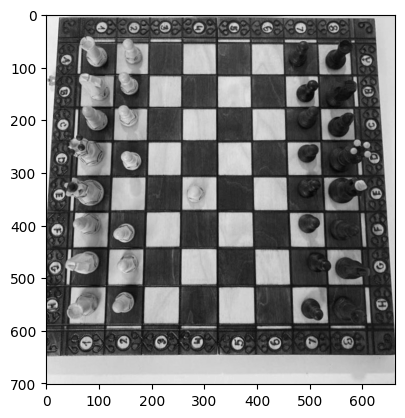

In [191]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

import os
print(os.getcwd())


def import_image(path):
    img = cv2.imread(path,1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_gray= cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    plt.imshow(img_gray, cmap = 'gray')
    plt.show()

    return img, img_gray

path = '../photos_test/guilhem_board/1.jpg'
# path = '../photos_test/mathian_board/0.png'
# path = '../photos_test/chess.com_game/1.jpg'
img, img_gray = import_image(path)


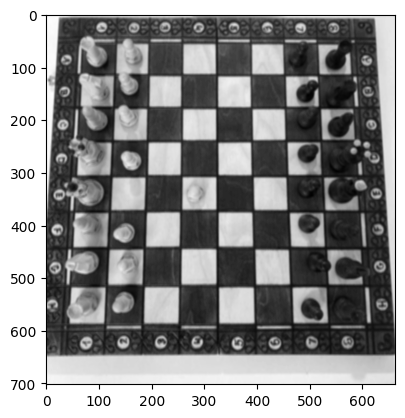

In [192]:
kernel_size = 5
sigma = 1.4

def apply_gaussian_blur(img_gray, kernel_size, sigma):
    gaussian_blur = cv2.GaussianBlur(img_gray, (kernel_size,kernel_size), sigma,sigma,cv2.BORDER_DEFAULT)
    return gaussian_blur

gaussian_blur = apply_gaussian_blur(img_gray, kernel_size, sigma)
plt.imshow(gaussian_blur, cmap = 'gray')
plt.show()

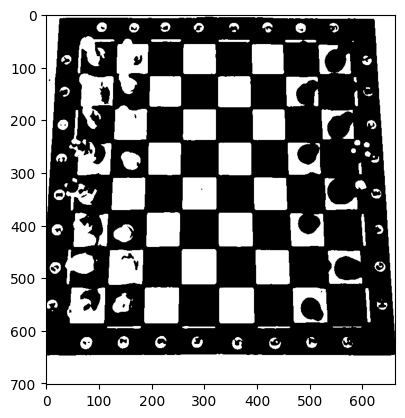

In [193]:
def apply_binary_threshold(img, threshold=128):
    height, width = img.shape
    binary_image = np.copy(img)
    for i in range(height):
        for j in range(width):
            if img[i,j] >=threshold:
                binary_image[i,j] = 255
            else :
                binary_image[i,j] = 0
    return binary_image

threshold = 128
binary_img = apply_binary_threshold(gaussian_blur, threshold)
plt.imshow(binary_img, cmap = 'gray')
plt.show()

# Sobel transformations

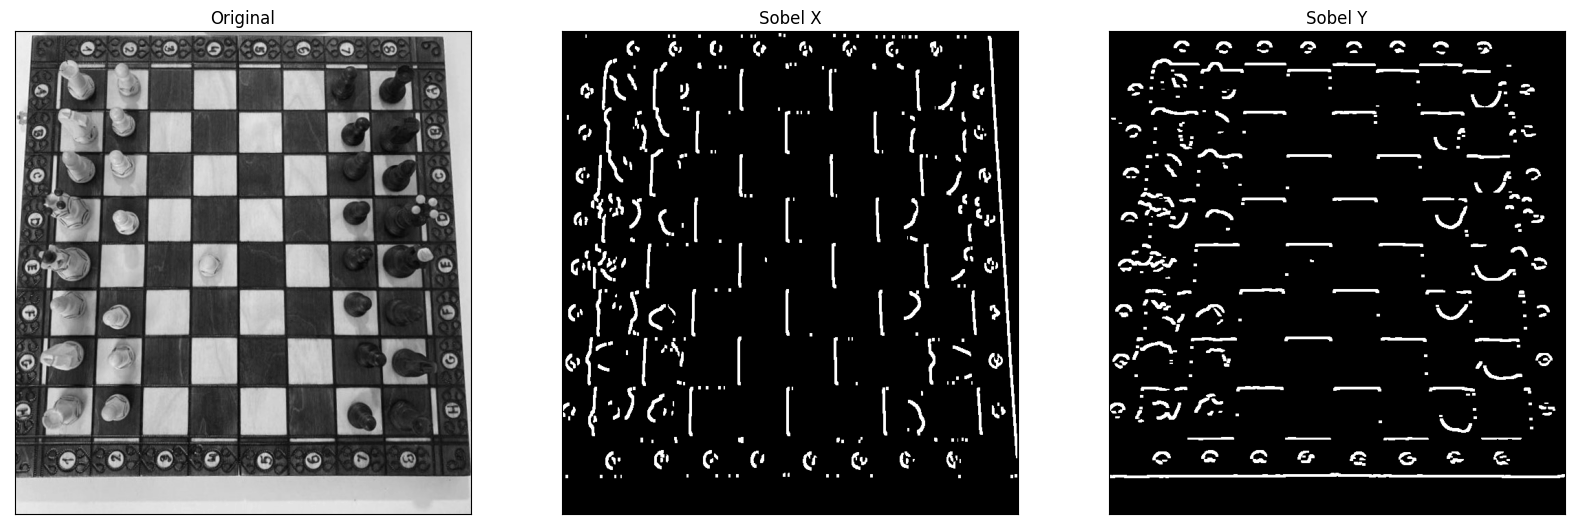

In [194]:
# avec sobel
def get_sobels(binary_img):
    sobelx = cv2.Sobel(binary_img,cv2.CV_8UC1,1,0,ksize=5)
    sobely = cv2.Sobel(binary_img,cv2.CV_8UC1,0,1,ksize=5)
    return sobelx, sobely
 
sobelx, sobely = get_sobels(binary_img)

plt.subplots(1, 3, figsize=(20,10))

plt.subplot(1,3,1),plt.imshow(img_gray,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,2),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,3),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])
plt.show()

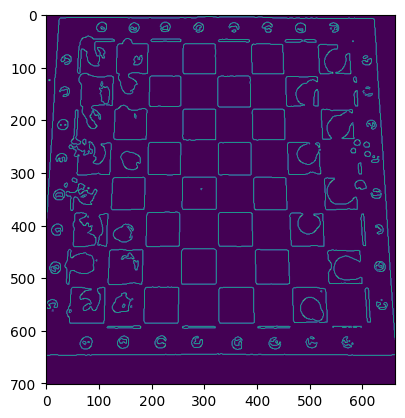

In [195]:
cdst = np.copy(img)

def get_edges(binary_img, threshold1 = 50, threshold2 = 150, apertureSize=3):
    edges = cv2.Canny(binary_img, threshold1, threshold2, apertureSize)
    return edges

edges = get_edges(binary_img)

plt.imshow(edges)
plt.show()


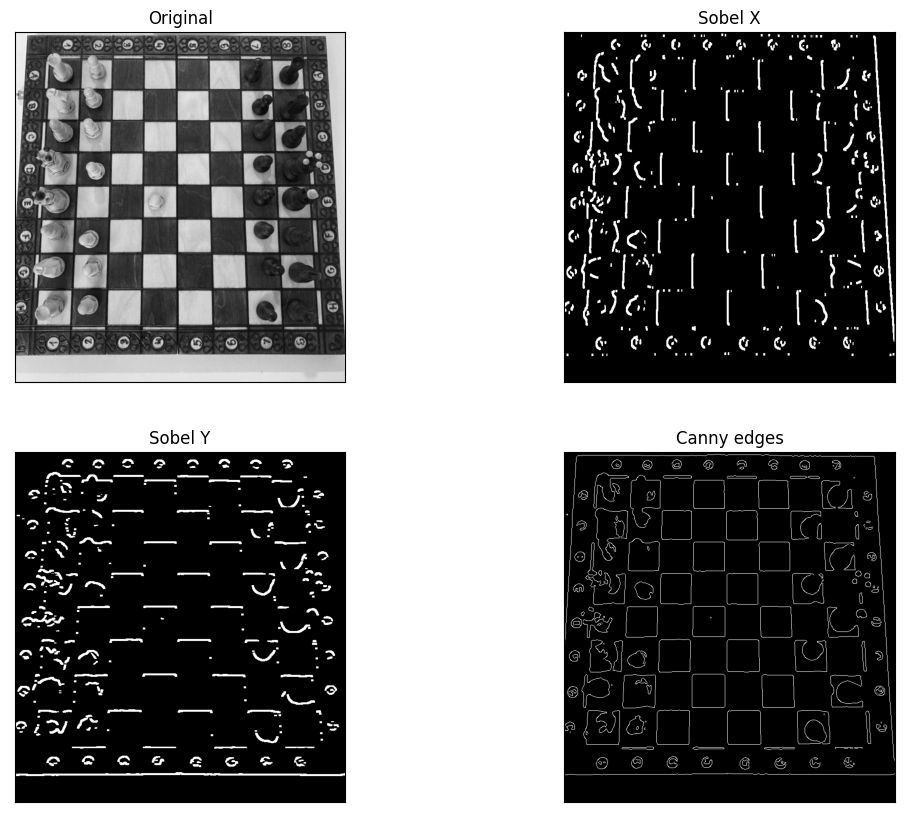

In [196]:
plt.subplots(2, 2, figsize=(13,10))

plt.subplot(2,2,1),plt.imshow(img_gray,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(edges,cmap = 'gray')
plt.title('Canny edges'), plt.xticks([]), plt.yticks([])
plt.show()

In [197]:
def get_points_full_line(l, width, height):
    x1, y1, x2, y2 = l[0], l[1], l[2], l[3]

    if x1 == x2 :
        return (x1, 0), (x2, height)
    
    if y1 == y2 :
        return (0, y1), (width, y1)
    
    slope = (y2 - y1) / (x2 - x1)
    ord_origin = y1 - slope * x1

    if y1 < y2 :
        return (0, round(ord_origin)), (round((height - ord_origin) / slope) , height)
    elif y1 > y2 :
        return (0, round(ord_origin)), (round(( - ord_origin) / slope) , 0)
        



In [198]:
def check_line_already_existing(point1, point2, points, epsilon):
    for (x1, y1), (x2, y2)  in points:
        if np.sqrt((point1[0] -x1)**2 + (point1[1] -y1)**2) < epsilon and np.sqrt((point2[0] -x2)**2 + (point2[1] -y2)**2):
            return True
    return False

def dist(p1, p2):
    return np.sqrt((p1[0]- p2[0])**2 + (p1[1]- p2[1])**2)


def get_intersection_between_2_lines(line1, line2): # line is characterized by two points : line = (p1, p2)
    (x1, y1), (x1prime, y1prime) = line1
    (x2, y2), (x2prime, y2prime) = line2
    if x1 == x1prime:
        if x2 == x2prime:
            return None
        slope2 = (y2 - y2prime) / (x2 - x2prime)
        ord_origin2 = y2 - slope2 * x2
        return (x1, round(slope2 * x1 + ord_origin2))
    elif x2 == x2prime:
        slope1 = (y1 - y1prime) / (x1 - x1prime)
        ord_origin1 = y1 - slope1 * x1
        return (x2, round(slope1 * x2 + ord_origin1))
    else:
        slope1 = (y1 - y1prime) / (x1 - x1prime)
        ord_origin1 = y1 - slope1 * x1
        slope2 = (y2 - y2prime) / (x2 - x2prime)
        ord_origin2 = y2 - slope2 * x2
        if slope1 == slope2:
            return None 
        x_int = - (ord_origin2 - ord_origin1) / (slope2 - slope1)
        y_int = slope1 * x_int + ord_origin1
        return (round(x_int), round(y_int))
    
def get_intersections(points):
    intersections = []
    for i in range(len(points)-1):
        for j in range(i+1, len(points)):
            intersections.append(get_intersection_between_2_lines(points[i], points[j]))
    return intersections



In [199]:
img_lines = np.copy(img)
img_lines_prolonged = np.copy(img)

# Probabilistic Line Transform

def get_houghlines(edges, threshold = 70, probabilistic=True):
    if not probabilistic:
        lines = cv2.HoughLines(edges, 1, np.pi / 180, 50, None, 0, 0)
    else :
        lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold, None, 50, 10)
    return lines

linesP = get_houghlines(edges, threshold = 28)

def get_median_length_linesP(linesP) :
    length_lines = []
    if linesP is not None:
        for i in range(0, len(linesP)):
            l = linesP[i][0]
            length_lines.append(dist((l[0],l[1]),(l[2], l[3])))
    return np.median(length_lines)
        

median_length_lines = get_median_length_linesP(linesP)
print(median_length_lines)

def get_points(linesP, median_length_lines, use_median = True):
    points = []
    # Draw the lines
    if linesP is not None:
        for i in range(0, len(linesP)):
            l = linesP[i][0]
            if use_median :
                if  median_length_lines - 20 < dist((l[0],l[1]),(l[2], l[3])) < median_length_lines +20:
                    point1, point2 = get_points_full_line(l, img.shape[1], img.shape[0])
                    if not check_line_already_existing(point1, point2, points, 30) :
                        points.append((point1, point2))
                        cv2.line(img_lines_prolonged, point1, point2, (0,0,255), 3, cv2.LINE_AA)  
                        cv2.line(img_lines, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)
            
            else : 
                point1, point2 = get_points_full_line(l, img.shape[1], img.shape[0])
                if not check_line_already_existing(point1, point2, points, 30) :
                    points.append((point1, point2))
                    cv2.line(img_lines_prolonged, point1, point2, (0,0,255), 3, cv2.LINE_AA)  
                    cv2.line(img_lines, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)
    
    return points

points = get_points(linesP, median_length_lines, use_median = True)

intersections = get_intersections(points)

58.59180830116101


In [200]:
img_intersections = np.copy(img)

for point in intersections:
    if point is not None :
        cv2.circle(img_intersections, (point[0], point[1]), 5, (0, 0, 255), -1)

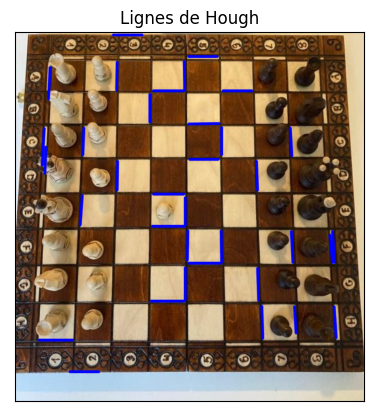

In [201]:
plt.title('Lignes de Hough'), plt.xticks([]), plt.yticks([])
plt.imshow(img_lines)

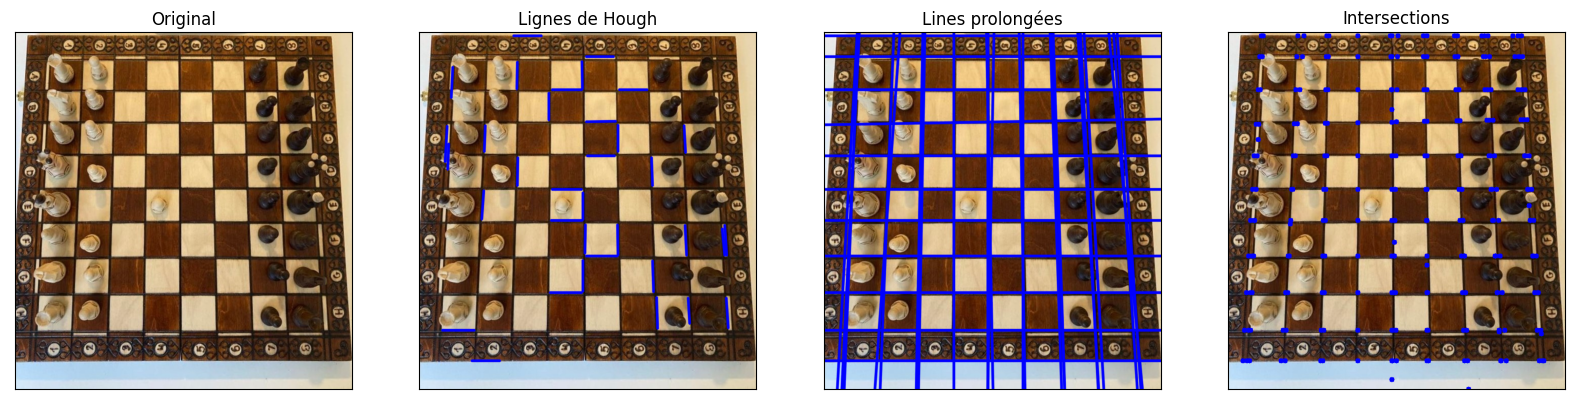

In [202]:
plt.subplots(1, 4, figsize=(20,10))

plt.subplot(1,4,1),plt.imshow(img)
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(1,4,2),plt.imshow(img_lines)
plt.title('Lignes de Hough'), plt.xticks([]), plt.yticks([])
plt.subplot(1,4,3),plt.imshow(img_lines_prolonged)
plt.title('Lines prolongées'), plt.xticks([]), plt.yticks([])
plt.subplot(1,4,4),plt.imshow(img_intersections)
plt.title('Intersections'), plt.xticks([]), plt.yticks([])
plt.show()

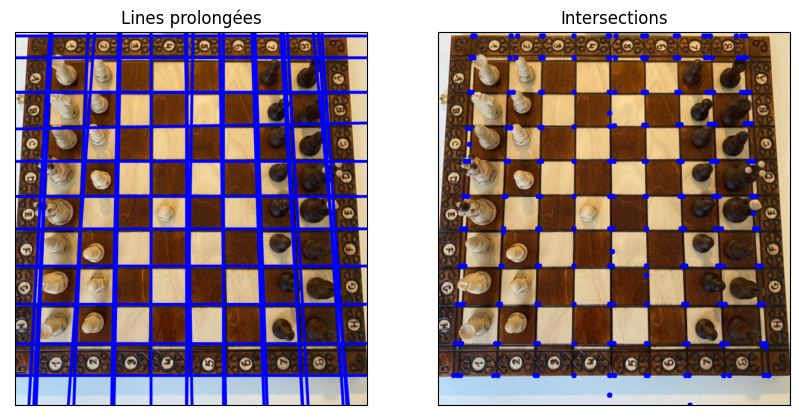

In [203]:
plt.subplots(1, 2, figsize=(10,5))

plt.subplot(1,2,1),plt.imshow(img_lines_prolonged)
plt.title('Lines prolongées'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(img_intersections)
plt.title('Intersections'), plt.xticks([]), plt.yticks([])
plt.show()

# group intersections


In [204]:
#clean intersections
old_intersections = np.copy(intersections)


def clean_intersections(intersections):
    clean_intersections = []

    for point in intersections:
        if point is None :
            continue
        x, y = point[0], point[1]
        if 0 <= x <= img.shape[1] and 0 <= y <= img.shape[0]:
            clean_intersections.append(point)

    return clean_intersections

intersections_cleaned = clean_intersections(intersections)

print(intersections_cleaned)


[(467, 512), (189, 512), (44, 512), (117, 512), (392, 512), (36, 512), (603, 512), (322, 512), (530, 512), (391, 512), (255, 512), (539, 512), (461, 512), (47, 512), (113, 512), (610, 512), (329, 512), (322, 512), (529, 512), (608, 512), (325, 512), (185, 512), (466, 512), (469, 586), (188, 586), (40, 586), (114, 586), (393, 586), (32, 586), (608, 586), (322, 586), (533, 586), (391, 586), (255, 586), (544, 586), (463, 586), (44, 586), (108, 586), (615, 586), (330, 586), (322, 586), (533, 586), (615, 586), (324, 586), (183, 586), (469, 586), (454, 113), (196, 113), (63, 113), (133, 113), (385, 113), (59, 113), (577, 113), (322, 113), (510, 113), (391, 113), (255, 113), (517, 113), (448, 113), (63, 113), (141, 113), (584, 113), (321, 113), (322, 113), (505, 113), (570, 113), (332, 113), (192, 113), (452, 113), (458, 243), (456, 174), (465, 440), (452, 48), (451, 7), (462, 370), (460, 309), (471, 646), (454, 113), (473, 702), (194, 243), (195, 179), (190, 440), (197, 48), (198, 7), (191, 

c:\Users\guilh\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:804: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)


In [205]:
def moyenne(points):
    return round(np.mean([point[0] for point in points])), round(np.mean([point[1] for point in points]))

def clusteriser_intersections(intersections, epsilon = 20):
    clusters = {}

    for i, point in enumerate(intersections) :
        if point is None :
            continue
        already_in_cluster = False
        for k in clusters.keys():
            if dist(point, moyenne(clusters[k])) <= epsilon:
                already_in_cluster = True
                clusters[k].append(point)
        if not already_in_cluster:
            clusters[i] = [point]

    return clusters

epsilon_points_clusters = 20
clusters = clusteriser_intersections(intersections_cleaned, epsilon_points_clusters)
print(clusters)

{0: [(467, 512), (461, 512), (466, 512)], 1: [(189, 512), (185, 512)], 2: [(44, 512), (36, 512), (47, 512)], 3: [(117, 512), (113, 512)], 4: [(392, 512), (391, 512)], 6: [(603, 512), (610, 512), (608, 512)], 7: [(322, 512), (329, 512), (322, 512), (325, 512)], 8: [(530, 512), (539, 512), (529, 512)], 10: [(255, 512)], 23: [(469, 586), (463, 586), (469, 586)], 24: [(188, 586), (183, 586)], 25: [(40, 586), (32, 586), (44, 586)], 26: [(114, 586), (108, 586)], 27: [(393, 586), (391, 586)], 29: [(608, 586), (615, 586), (615, 586), (616, 593)], 30: [(322, 586), (330, 586), (322, 586), (324, 586)], 31: [(533, 586), (544, 586), (533, 586), (533, 589)], 33: [(255, 586)], 46: [(454, 113), (448, 113), (452, 113), (454, 113), (448, 113), (452, 113)], 47: [(196, 113), (192, 113), (196, 113), (192, 113)], 48: [(63, 113), (59, 113), (63, 113), (63, 113), (59, 113), (63, 113)], 49: [(133, 113), (141, 113), (133, 113), (141, 113)], 50: [(385, 113), (391, 113), (385, 113), (391, 113)], 52: [(577, 113), 

In [206]:
def group_clusters(clusters):
    new_intersections = []

    for k in clusters.keys():
        new_intersections.append(moyenne(clusters[k]))

    return new_intersections

new_intersections = group_clusters(clusters)

print(new_intersections)
print(len(new_intersections))

[(465, 512), (187, 512), (42, 512), (115, 512), (392, 512), (607, 512), (324, 512), (533, 512), (255, 512), (467, 586), (186, 586), (39, 586), (111, 586), (392, 586), (614, 588), (324, 586), (536, 587), (255, 586), (451, 113), (194, 113), (62, 113), (137, 113), (388, 113), (577, 113), (324, 113), (511, 113), (255, 113), (456, 243), (453, 174), (463, 440), (449, 48), (448, 7), (460, 370), (458, 309), (469, 646), (473, 702), (192, 243), (193, 179), (188, 440), (195, 48), (196, 7), (189, 370), (190, 309), (184, 646), (55, 243), (130, 243), (389, 243), (587, 243), (324, 243), (518, 243), (255, 243), (58, 181), (133, 180), (388, 175), (582, 172), (324, 177), (514, 173), (255, 178), (46, 440), (65, 48), (67, 7), (49, 370), (52, 309), (59, 211), (36, 646), (119, 440), (140, 48), (143, 7), (123, 372), (126, 309), (108, 646), (391, 446), (602, 440), (324, 440), (529, 440), (255, 440), (388, 48), (388, 7), (390, 370), (390, 309), (392, 646), (572, 48), (324, 48), (507, 48), (255, 48), (569, 7), 

In [207]:
img_new_intersections = np.copy(img)

for point in new_intersections:
    if point is not None :
        cv2.circle(img_new_intersections, (point[0], point[1]), 5, (0, 0, 255), -1)

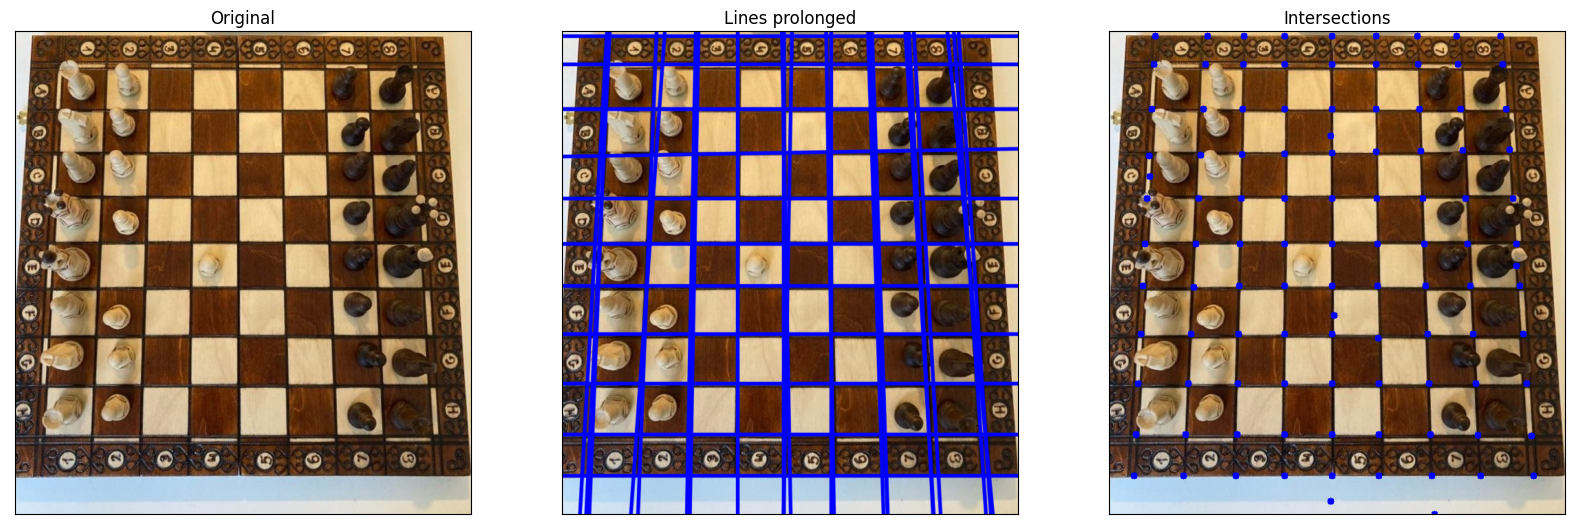

In [208]:
plt.subplots(1, 3, figsize=(20,10))

plt.subplot(1,3,1),plt.imshow(img)
plt.title('Original'), plt.xticks([]), plt.yticks([])
# plt.subplot(1,3,2),plt.imshow(img_lines)
# plt.title('HoughLinesP'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,2),plt.imshow(img_lines_prolonged)
plt.title('Lines prolonged'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,3),plt.imshow(img_new_intersections)
plt.title('Intersections'), plt.xticks([]), plt.yticks([])
plt.show()

In [209]:
def moyenne_y(points):
    return round(np.mean([point[1] for point in points]))

def moyenne_x(points):
    return round(np.mean([point[0] for point in points]))

def dist_y(y1, y2):
    return np.abs(y1-y2)

def dist_x(x1, x2):
    return np.abs(x1-x2)


def cluster_along_y(intersections, epsilon_y):
    clusters_y = {}

    for i, point in enumerate(intersections) :
        already_in_cluster = False
        for k in clusters_y.keys():
            if dist_y(point[1], moyenne_y(clusters_y[k])) <= epsilon_y:
                already_in_cluster = True
                clusters_y[k].append(point)
        if not already_in_cluster:
            clusters_y[i] = [point]

    return clusters_y

def cluster_along_x(intersections, epsilon_x):
    clusters_x = {}

    for i, point in enumerate(intersections) :
        already_in_cluster = False
        for k in clusters_x.keys():
            if dist_x(point[0], moyenne_x(clusters_x[k])) <= epsilon_x:
                already_in_cluster = True
                clusters_x[k].append(point)
        if not already_in_cluster:
            clusters_x[i] = [point]

    return clusters_x



# print(clusters_y)
# for k, v in clusters_y.items():
#     print(k, len(v))


In [210]:
img_anomaly = np.copy(img)
img_non_anomaly = np.copy(img)

def remove_y_anomalies(anomaly_points, lines_interests_points_y, clusters_y):
    for k in clusters_y.keys():
        if len(clusters_y[k]) <=3 :
            for point in clusters_y[k] :
                anomaly_points.append(point)
                cv2.circle(img_anomaly, (point[0], point[1]), 10, (0, 0, 255), -1)
                cv2.circle(img_non_anomaly, (point[0], point[1]), 10, (255, 0, 0), -1)


        else :
            lines_interests_points_y[k] = clusters_y[k]
            for point in clusters_y[k] :
                # non_anomaly_points.append(point)
                cv2.circle(img_non_anomaly, (point[0], point[1]), 10, (0, 0, 255), -1)

    return anomaly_points, lines_interests_points_y


def remove_x_anomalies(anomaly_points, lines_interests_points_x, clusters_x):
    for k in clusters_x.keys():
        if len(clusters_x[k]) <=3 :
            for point in clusters_x[k] :
                anomaly_points.append(point)
                cv2.circle(img_anomaly, (point[0], point[1]), 10, (0, 0, 255), -1)
                cv2.circle(img_non_anomaly, (point[0], point[1]), 10, (255, 0, 0), -1)

        else :
            lines_interests_points_x[k] = clusters_x[k]
    return anomaly_points, lines_interests_points_x

def remove_anomalies(intersections, epsilon_x=25, epsilon_y=10):

    clusters_x = cluster_along_x(intersections, epsilon_x)
    anomaly_points, lines_interests_points_x = remove_x_anomalies([], {}, clusters_x)

    new_intersections = [point for line_x in lines_interests_points_x.values() for point in line_x ]
    clusters_y = cluster_along_y(new_intersections, epsilon_y)
    anomaly_points, lines_interests_points_y = remove_y_anomalies(anomaly_points, {}, clusters_y)

    for k, v in lines_interests_points_y.items():
        lines_interests_points_y[k] = list(set(v))

    return lines_interests_points_y, anomaly_points

lines_interests_points_y, anomaly_points = remove_anomalies(new_intersections)


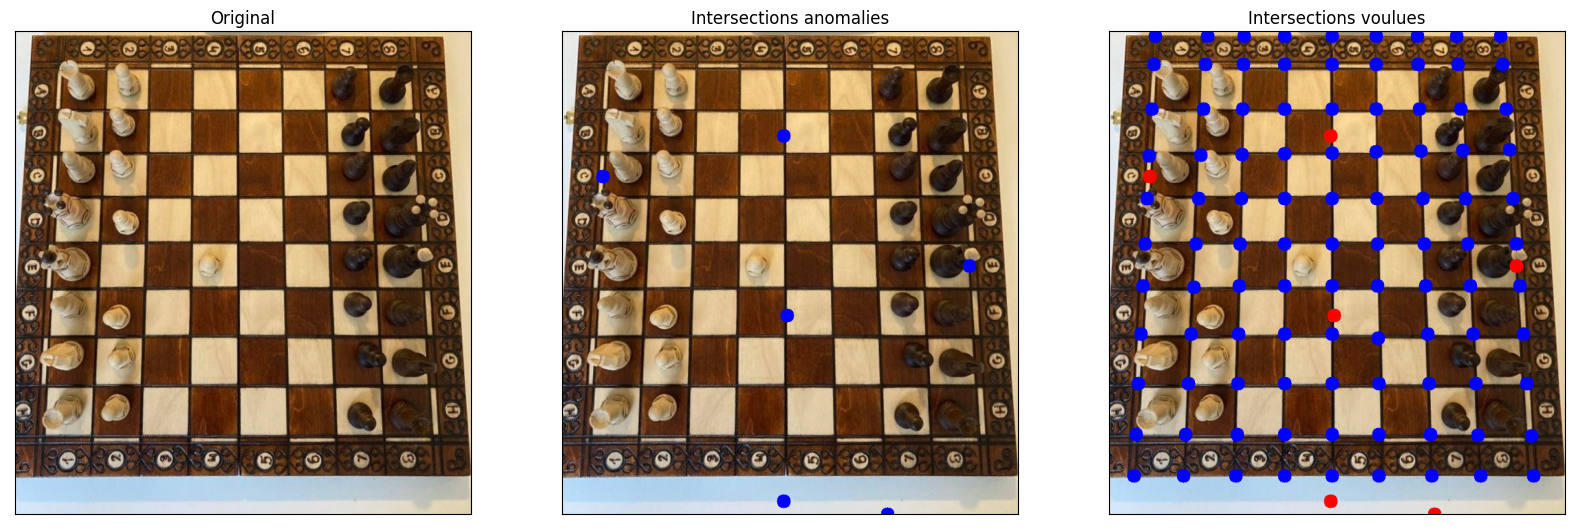

In [211]:
plt.subplots(1, 3, figsize=(20,10))

plt.subplot(1,3,1),plt.imshow(img)
plt.title('Original'), plt.xticks([]), plt.yticks([])
# plt.subplot(1,3,2),plt.imshow(img_lines)
# plt.title('HoughLinesP'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,2),plt.imshow(img_anomaly)
plt.title('Intersections anomalies'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,3),plt.imshow(img_non_anomaly)
plt.title('Intersections voulues'), plt.xticks([]), plt.yticks([])
plt.show()

(Text(0.5, 1.0, 'Intersections voulues et anomalies'), ([], []), ([], []))

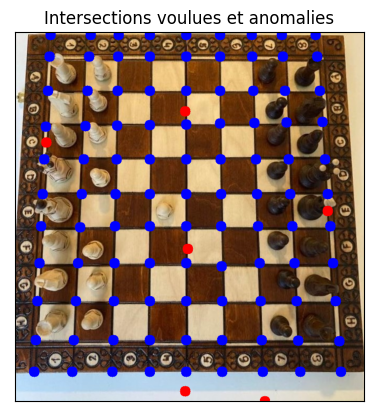

In [212]:
plt.imshow(img_non_anomaly)
plt.title('Intersections voulues et anomalies'), plt.xticks([]), plt.yticks([])

## Sorting 

In [213]:
def sort_lines_of_interest_by_y(lines_interests_points_y):

    # cols = {} 
    cols = []
    moyennes_y = [moyenne_y(lines_interests_points_y[k]) for k in lines_interests_points_y.keys()]
    moyennes_y_sorted =  sorted(moyennes_y)
    print(lines_interests_points_y)

    print(moyennes_y_sorted)

    for i, letter in zip(range(len(moyennes_y)), 'abcdefghijkl'[:len(moyennes_y)]):
        mean = moyennes_y_sorted[i]
        corresponding_k = None
        for k in lines_interests_points_y.keys():
            if moyenne_y(lines_interests_points_y[k]) == mean :
                corresponding_k = k
        # cols[letter] = lines_interests_points_y[corresponding_k]
        cols.append(lines_interests_points_y[corresponding_k])

    # for k in cols.keys():
    for k in range(len(cols)):
        cols[k].sort(key=lambda x : x[0])
    
    return cols

cols_sorted = sort_lines_of_interest_by_y(lines_interests_points_y)
    

{0: [(115, 512), (324, 512), (533, 512), (465, 512), (392, 512), (607, 512), (255, 512), (42, 512), (187, 512)], 1: [(467, 586), (324, 586), (392, 586), (39, 586), (186, 586), (614, 588), (255, 586), (536, 587), (111, 586)], 2: [(324, 113), (137, 113), (577, 113), (62, 113), (451, 113), (511, 113), (194, 113), (255, 113), (388, 113)], 3: [(55, 243), (456, 243), (518, 243), (130, 243), (255, 243), (587, 243), (389, 243), (324, 243), (192, 243)], 4: [(58, 181), (193, 179), (324, 177), (514, 173), (453, 174), (133, 180), (255, 178), (582, 172), (388, 175)], 5: [(602, 440), (255, 440), (324, 440), (529, 440), (46, 440), (391, 446), (188, 440), (463, 440), (119, 440)], 6: [(255, 48), (449, 48), (388, 48), (324, 48), (140, 48), (507, 48), (195, 48), (65, 48), (572, 48)], 7: [(388, 7), (505, 7), (196, 7), (324, 7), (67, 7), (448, 7), (569, 7), (143, 7), (255, 7)], 8: [(525, 370), (460, 370), (597, 370), (49, 370), (324, 370), (189, 370), (390, 370), (123, 372), (255, 370)], 9: [(390, 309), (5

In [214]:
def remove_chessboard_contours(cols_sorted):
    # if len(cols_sorted.keys()) == 9 and len(cols_sorted[list(cols_sorted.keys())[0]]) == 9:
    print(len(cols_sorted))
    if len(cols_sorted) == 9 and len(cols_sorted[0]) == 9 :
        return cols_sorted
    
    if len(cols_sorted) == 11 :
        del cols_sorted[0]
        del cols_sorted[-1]

    elif len(cols_sorted) == 10 :
        nb = len(cols_sorted)
        means_y = [moyenne_y(cols_sorted[i]) for i in range(nb)]
        print(means_y)
        mean_y_distance = np.mean([means_y[i+1] - means_y[i] for i in range(nb-1)])
        if means_y[1] - means_y[0] < means_y[-1] - means_y[-2]:
            del cols_sorted[0]
        elif means_y[1] - means_y[0] > means_y[-1] - means_y[-2]:
            del cols_sorted[-1]

    for i in range(len(cols_sorted)):
        if len(cols_sorted[i]) == 11 :
            del cols_sorted[i][0]
            del cols_sorted[i][-1]

        elif len(cols_sorted[i]) == 10 :
            nb = len(cols_sorted[i])
            mean_x_distance = np.mean([cols_sorted[i][j+1][0] - cols_sorted[i][j][0] for j in range(nb-1)])
            if cols_sorted[i][1][0] - cols_sorted[i][0][0] < mean_x_distance:
                del cols_sorted[i][0]
            elif cols_sorted[i][-1][0] - cols_sorted[i][-2][0] < mean_x_distance:
                del cols_sorted[i][-1]

    return cols_sorted

cols_sorted = remove_chessboard_contours(cols_sorted)



11


In [215]:
def get_chessboard_boxes(cols_sorted):
    boxes = {}
    letters = 'abcdefgh'
    nums= '12345678'
    for i in range(8):
        for j in range(8):
            letter = letters[i]
            num = nums[j]
            boxes[letter+num] = [cols_sorted[i][j], cols_sorted[i][j+1], cols_sorted[i+1][j], cols_sorted[i+1][j+1]]

    return boxes

boxes = get_chessboard_boxes(cols_sorted)

In [216]:
print(boxes)

{'a1': [(65, 48), (140, 48), (62, 113), (137, 113)], 'a2': [(140, 48), (195, 48), (137, 113), (194, 113)], 'a3': [(195, 48), (255, 48), (194, 113), (255, 113)], 'a4': [(255, 48), (324, 48), (255, 113), (324, 113)], 'a5': [(324, 48), (388, 48), (324, 113), (388, 113)], 'a6': [(388, 48), (449, 48), (388, 113), (451, 113)], 'a7': [(449, 48), (507, 48), (451, 113), (511, 113)], 'a8': [(507, 48), (572, 48), (511, 113), (577, 113)], 'b1': [(62, 113), (137, 113), (58, 181), (133, 180)], 'b2': [(137, 113), (194, 113), (133, 180), (193, 179)], 'b3': [(194, 113), (255, 113), (193, 179), (255, 178)], 'b4': [(255, 113), (324, 113), (255, 178), (324, 177)], 'b5': [(324, 113), (388, 113), (324, 177), (388, 175)], 'b6': [(388, 113), (451, 113), (388, 175), (453, 174)], 'b7': [(451, 113), (511, 113), (453, 174), (514, 173)], 'b8': [(511, 113), (577, 113), (514, 173), (582, 172)], 'c1': [(58, 181), (133, 180), (55, 243), (130, 243)], 'c2': [(133, 180), (193, 179), (130, 243), (192, 243)], 'c3': [(193, 

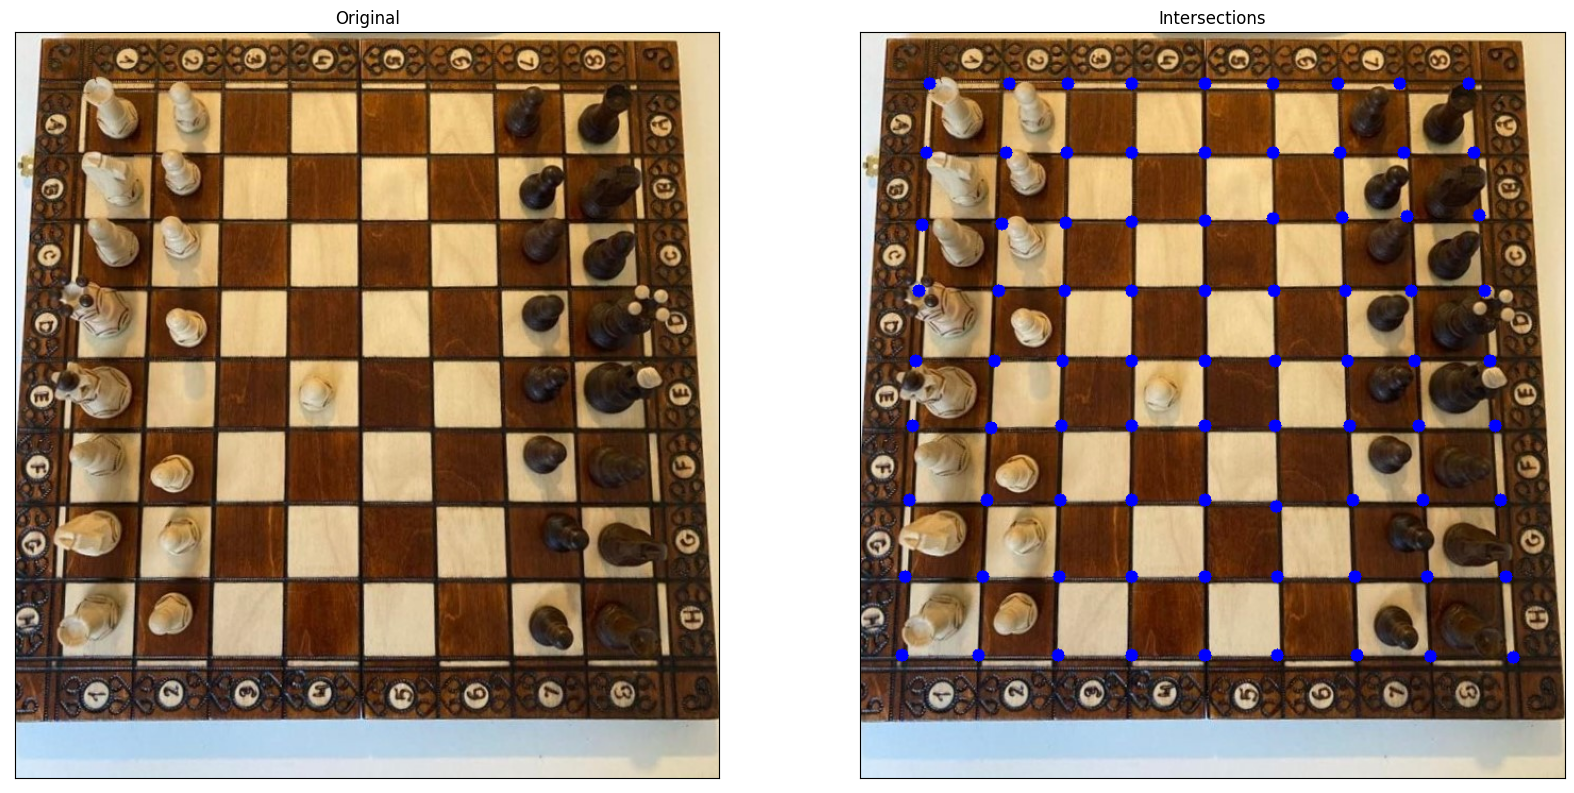

In [217]:
img_copy = np.copy(img)
for line in cols_sorted:
    for point in line :
        cv2.circle(img_copy, (point[0], point[1]), 6, (0, 0, 255), -1)


plt.subplots(1, 2, figsize=(20,10))

plt.subplot(1,2,1),plt.imshow(img)
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(img_copy)
plt.title('Intersections'), plt.xticks([]), plt.yticks([])
plt.show()

In [218]:
img_boxes_test = np.copy(img)

for point in boxes['e4']:
    cv2.circle(img_boxes_test, (point[0], point[1]), 8, (0, 0, 255), -1)

for point in boxes['h3']:
    cv2.circle(img_boxes_test, (point[0], point[1]), 8, (0, 0, 255), -1)

for point in boxes['b5']:
    cv2.circle(img_boxes_test, (point[0], point[1]), 8, (0, 0, 255), -1)

for point in boxes['f1']:
    cv2.circle(img_boxes_test, (point[0], point[1]), 8, (0, 0, 255), -1)
    

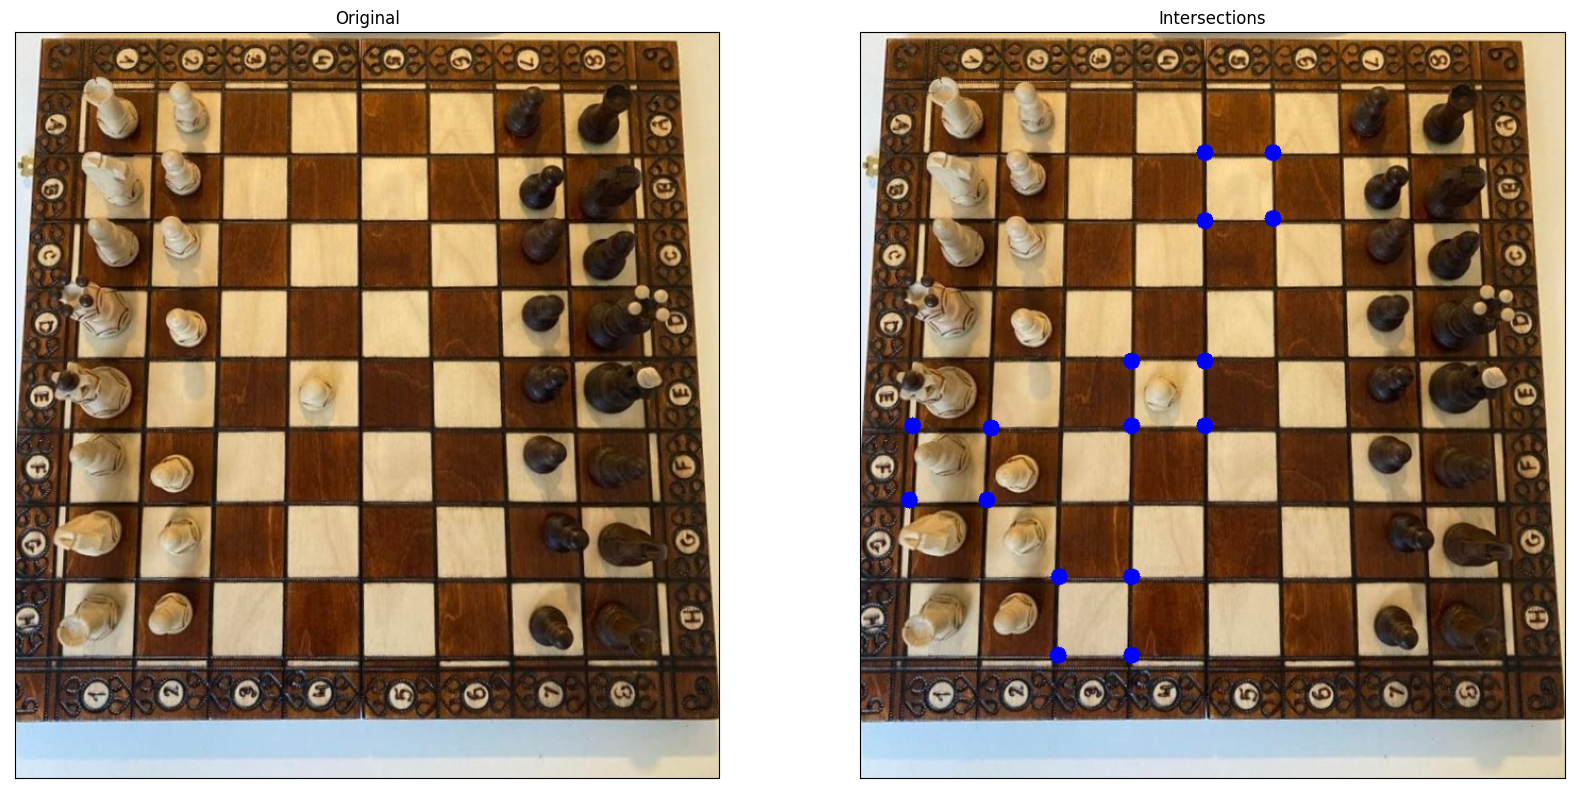

In [219]:
plt.subplots(1, 2, figsize=(20,10))

plt.subplot(1,2,1),plt.imshow(img)
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(img_boxes_test)
plt.title('Intersections'), plt.xticks([]), plt.yticks([])
plt.show()

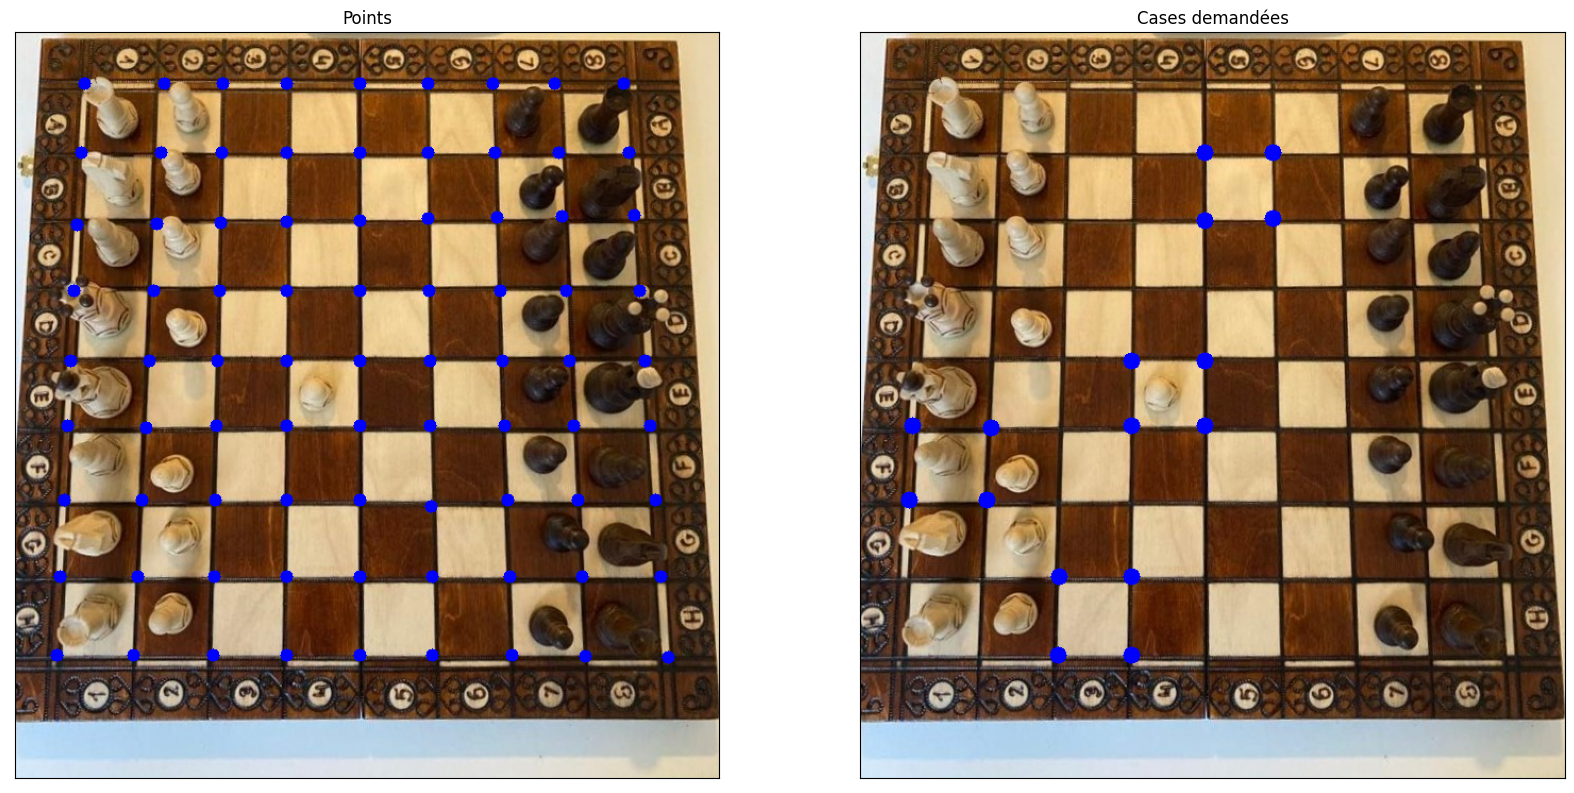

In [220]:
plt.subplots(1, 2, figsize=(20,10))

plt.subplot(1,2,1),plt.imshow(img_copy)
plt.title('Points'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(img_boxes_test)
plt.title('Cases demandées'), plt.xticks([]), plt.yticks([])
plt.show()